# lorapy data processing

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
# from lorapy.io.load import DatLoader
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
OTA_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_OTA')
OUTDOOR_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_Outdoor')

## utils

In [4]:
import random
rand = lambda mx: random.randint(0, mx)

# load

In [33]:
loader = lorapy.load(OUTDOOR_DATA_DIR, autoload=True)
loader.file_list

2020-04-06 13:43:04.560 | DEBUG    | lorapy.io._base_loader:_validate_data_path:129 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/LoRa_Recording_Outdoor
2020-04-06 13:43:04.563 | INFO     | lorapy.io._base_loader:_process_data_dir:142 - found 20 data file(s)
2020-04-06 13:43:04.565 | INFO     | lorapy.io.load:__init__:25 - initialized DatLoader


[DatFile(id=0 | name='lora_BW9_SF8_915MHz_1Msps_L42.dat'),
 DatFile(id=1 | name='lora_BW8_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=2 | name='lora_BW2_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=3 | name='lora_BW8_SF11_915_25MHz_1Msps_L37.dat'),
 DatFile(id=4 | name='lora_BW8_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=5 | name='lora_BW9_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=6 | name='lora_BW2_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=7 | name='lora_BW9_SF10_915MHz_1Msps_L1.dat'),
 DatFile(id=8 | name='lora_BW1_SF12_915MHz_1Msps_Att70_v3.dat'),
 DatFile(id=9 | name='lora_BW7_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=10 | name='lora_BW1_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=11 | name='lora_BW1_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=12 | name='lora_BW7_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=13 | name='lora_BW2_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=14 | name='lora_BW8_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=15 | name='lora_BW1_SF

In [34]:
loader.select(file_id=18)

DatFile(id=18 | name='lora_BW1_SF11_915MHz_1Msps_Att70_v3.dat')

In [36]:
loader.filter(bw=7)

[DatFile(id=9 | name='lora_BW7_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=12 | name='lora_BW7_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile(id=16 | name='lora_BW7_SF12_915MHz_1Msps_Att80_v0.dat')]

In [37]:
loader.filter(bw=2, sf=11)

[DatFile(id=13 | name='lora_BW2_SF11_915MHz_1Msps_Att80_v0.dat')]

In [ ]:
tar_filename = 'lora_BW9_SF10_915MHz_1Msps_L1.dat'

file = [file for file in loader.filelist if file.name == tar_filename][0]
file

In [39]:
file = loader.filter(bw=9, sf=10)[0]
file

DatFile(id=7 | name='lora_BW9_SF10_915MHz_1Msps_L1.dat')

# process

## convert 

In [ ]:
signal = file.to_signal()
signal

## stats 

In [ ]:
signal.stats

## plots

In [ ]:
signal.plot(real=True, stop=180_000, color='blue')

# packets

## extract - auto adjust

## extract - manual adjust

In [ ]:
signal.extract_packets(method='slide-mean', auto_adj=False, overlap=0.7)

In [ ]:
signal.adjust_packets(force_check=True, look_ahead=100, threshold=0.5)

In [ ]:
signal.plot_packet(real=False)

## inspect

In [ ]:
for packet in signal.packets[:14]:
    pass
    
packet

In [ ]:
packet.plot(real=False)

# symbols

In [ ]:
packet = signal.random_packet
packet.plot()
display(packet)

## extraction

In [ ]:
packet.extract_preamble_symbols()

In [ ]:
packet.plot_symbol(real=False)

## inspection

In [ ]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

## convolution

In [ ]:
symbol.plot()

### setup `.p` reference

In [41]:
loader = lorapy.load(OUTDOOR_DATA_DIR, autoload=False, glob_pattern='**/*BW9*.p')
p_file_path = loader.file_path
p_file_path

2020-04-06 14:30:28.709 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/LoRa_Recording_Outdoor
2020-04-06 14:30:28.711 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 1 data file(s)


PosixPath('/Users/trevor/Work/1-projects/lora-processing/data/LoRa_Recording_Outdoor/lora_symbols_BW9_SF10.p')

In [49]:
from six.moves import cPickle
with p_file_path.open('rb') as pfile:
    baseline = cPickle.load(pfile)

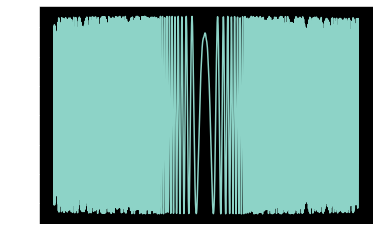

In [42]:
baseline = baseline[1,:]
plt.plot(np.real(baseline))

## convolve - builtin

In [ ]:
symbol.convolve(baseline)

## signal all together

In [ ]:
packet = signal.random_packet
packet.extract_preamble_symbols()

packet.plot()
display(packet)

In [ ]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

In [ ]:
symbol.convolve(baseline)

In [ ]:
symbol.absolute_endpoints

In [ ]:
signal.plot(real=False, start=symbol.absolute_endpoints[0], stop=symbol.absolute_endpoints[1])

In [ ]:
signal.stats.filename

## conv scratch

In [ ]:
baseline = baseline[0:signal.stats.samp_per_sym]

c_out = []

for i in range(symbols.shape[0]):
    sig = symbols[i,:]
    sig_c = np.conj(sig[::-1])
    conv_val = np.abs(np.convolve(baseline,sig_c))/np.linalg.norm(sig)/np.linalg.norm(sig)

    c_out.append(np.max(conv_val))

fig = plt.figure(figsize=(15,5))
plt.plot(c_out)